In [2]:
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import copy
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
root = os.getcwd()
data_path = os.path.join(root, 'data')
print(data_path)

/home/patrik/repos/ai/data


In [6]:
names_file_path = os.path.join(data_path, 'obj.names')
with open(names_file_path, 'r') as f:
    labels_names = f.read().splitlines()

print(labels_names)


['person', 'vehicle']


In [ ]:
# read file names in directory and return list of image names
image_files = []
label_files = []
dirpath = os.path.join(data_path, 'dataset')
for file in os.listdir(dirpath):
    if file.endswith(('.jpg', '.png')):
        image_path = os.path.join(dirpath, file)
        # check if for each image exist corresponding txt file, if yes, return list of images, else error
        txt_file = os.path.splitext(image_path)[0] + '.txt'
        if os.path.isfile(txt_file):
            image_files.append(image_path)
            label_files.append(txt_file)
        else:
            print(f"Error: Corresponding txt file does not exist for image {image_path}")

In [ ]:
data_tuples = []

for label_file in label_files:
    with open(label_file, 'r') as f:
        data = f.read().splitlines()
        df = pd.DataFrame(columns=["class_id", "x_center", "y_center", "width", "height"])
        df = pd.DataFrame([sub.split(" ") for sub in data], columns=df.columns)
        #Assuming class_id is stored as an integer, if not, you may need to convert it
        df['class_id'] = df['class_id'].astype(int)
        # Map the class_id to the label names
        df['class_id'] = df['class_id'].map(lambda x: labels_names[x])

        file_data_tuple = (os.path.basename(label_file), df)
        data_tuples.append(file_data_tuple)

In [ ]:
# Count Pictures Per Class
pictures_per_class = {}
for _, df in data_tuples:
    for class_id in df['class_id'].unique():
        if class_id in pictures_per_class:
            pictures_per_class[class_id] += 1
        else:
            pictures_per_class[class_id] = 1

print("\nCount of Pictures per Class:")
print(pictures_per_class)


Count of Pictures per Class:
{'person': 41, 'vehicle': 13}


In [ ]:
# Aggregate all DataFrames
all_data = pd.concat([df for _, df in data_tuples])

# Count Instances Per Class
instances_per_class = all_data['class_id'].value_counts()
print("Count of Instances per Class:")
print(instances_per_class)


Count of Instances per Class:
class_id
person     88
vehicle    35
Name: count, dtype: int64


In [ ]:

train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

In [ ]:
# Define the target directories
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')
val_dir = os.path.join(data_path, 'val')

# Create the target directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
# Get the names of the directories in a list

In [ ]:
image_size=640

In [ ]:
def resize_and_copy_data(source_list, target_dir):
    for file in source_list:
        # Get the target file name
        image_path = os.path.join(dirpath, os.path.basename(file))
        # Read the image
        image = cv2.imread(image_path)
        # Resize the image
        img_resized = cv2.resize(image, (image_size, image_size))
        # Save the image with the target name
        new_image_path = os.path.join(target_dir, os.path.basename(file))
        cv2.imwrite(new_image_path, img_resized)
        
        # Copy the text file with the same name
        txt_file = os.path.splitext(image_path)[0] + '.txt'
        new_txt_file_path = os.path.join(target_dir, os.path.basename(txt_file))
        shutil.copy(txt_file, new_txt_file_path)


In [ ]:
# Load, resize, and copy the images
resize_and_copy_data(train_files, train_dir)
resize_and_copy_data(test_files, test_dir)
resize_and_copy_data(val_files, val_dir)

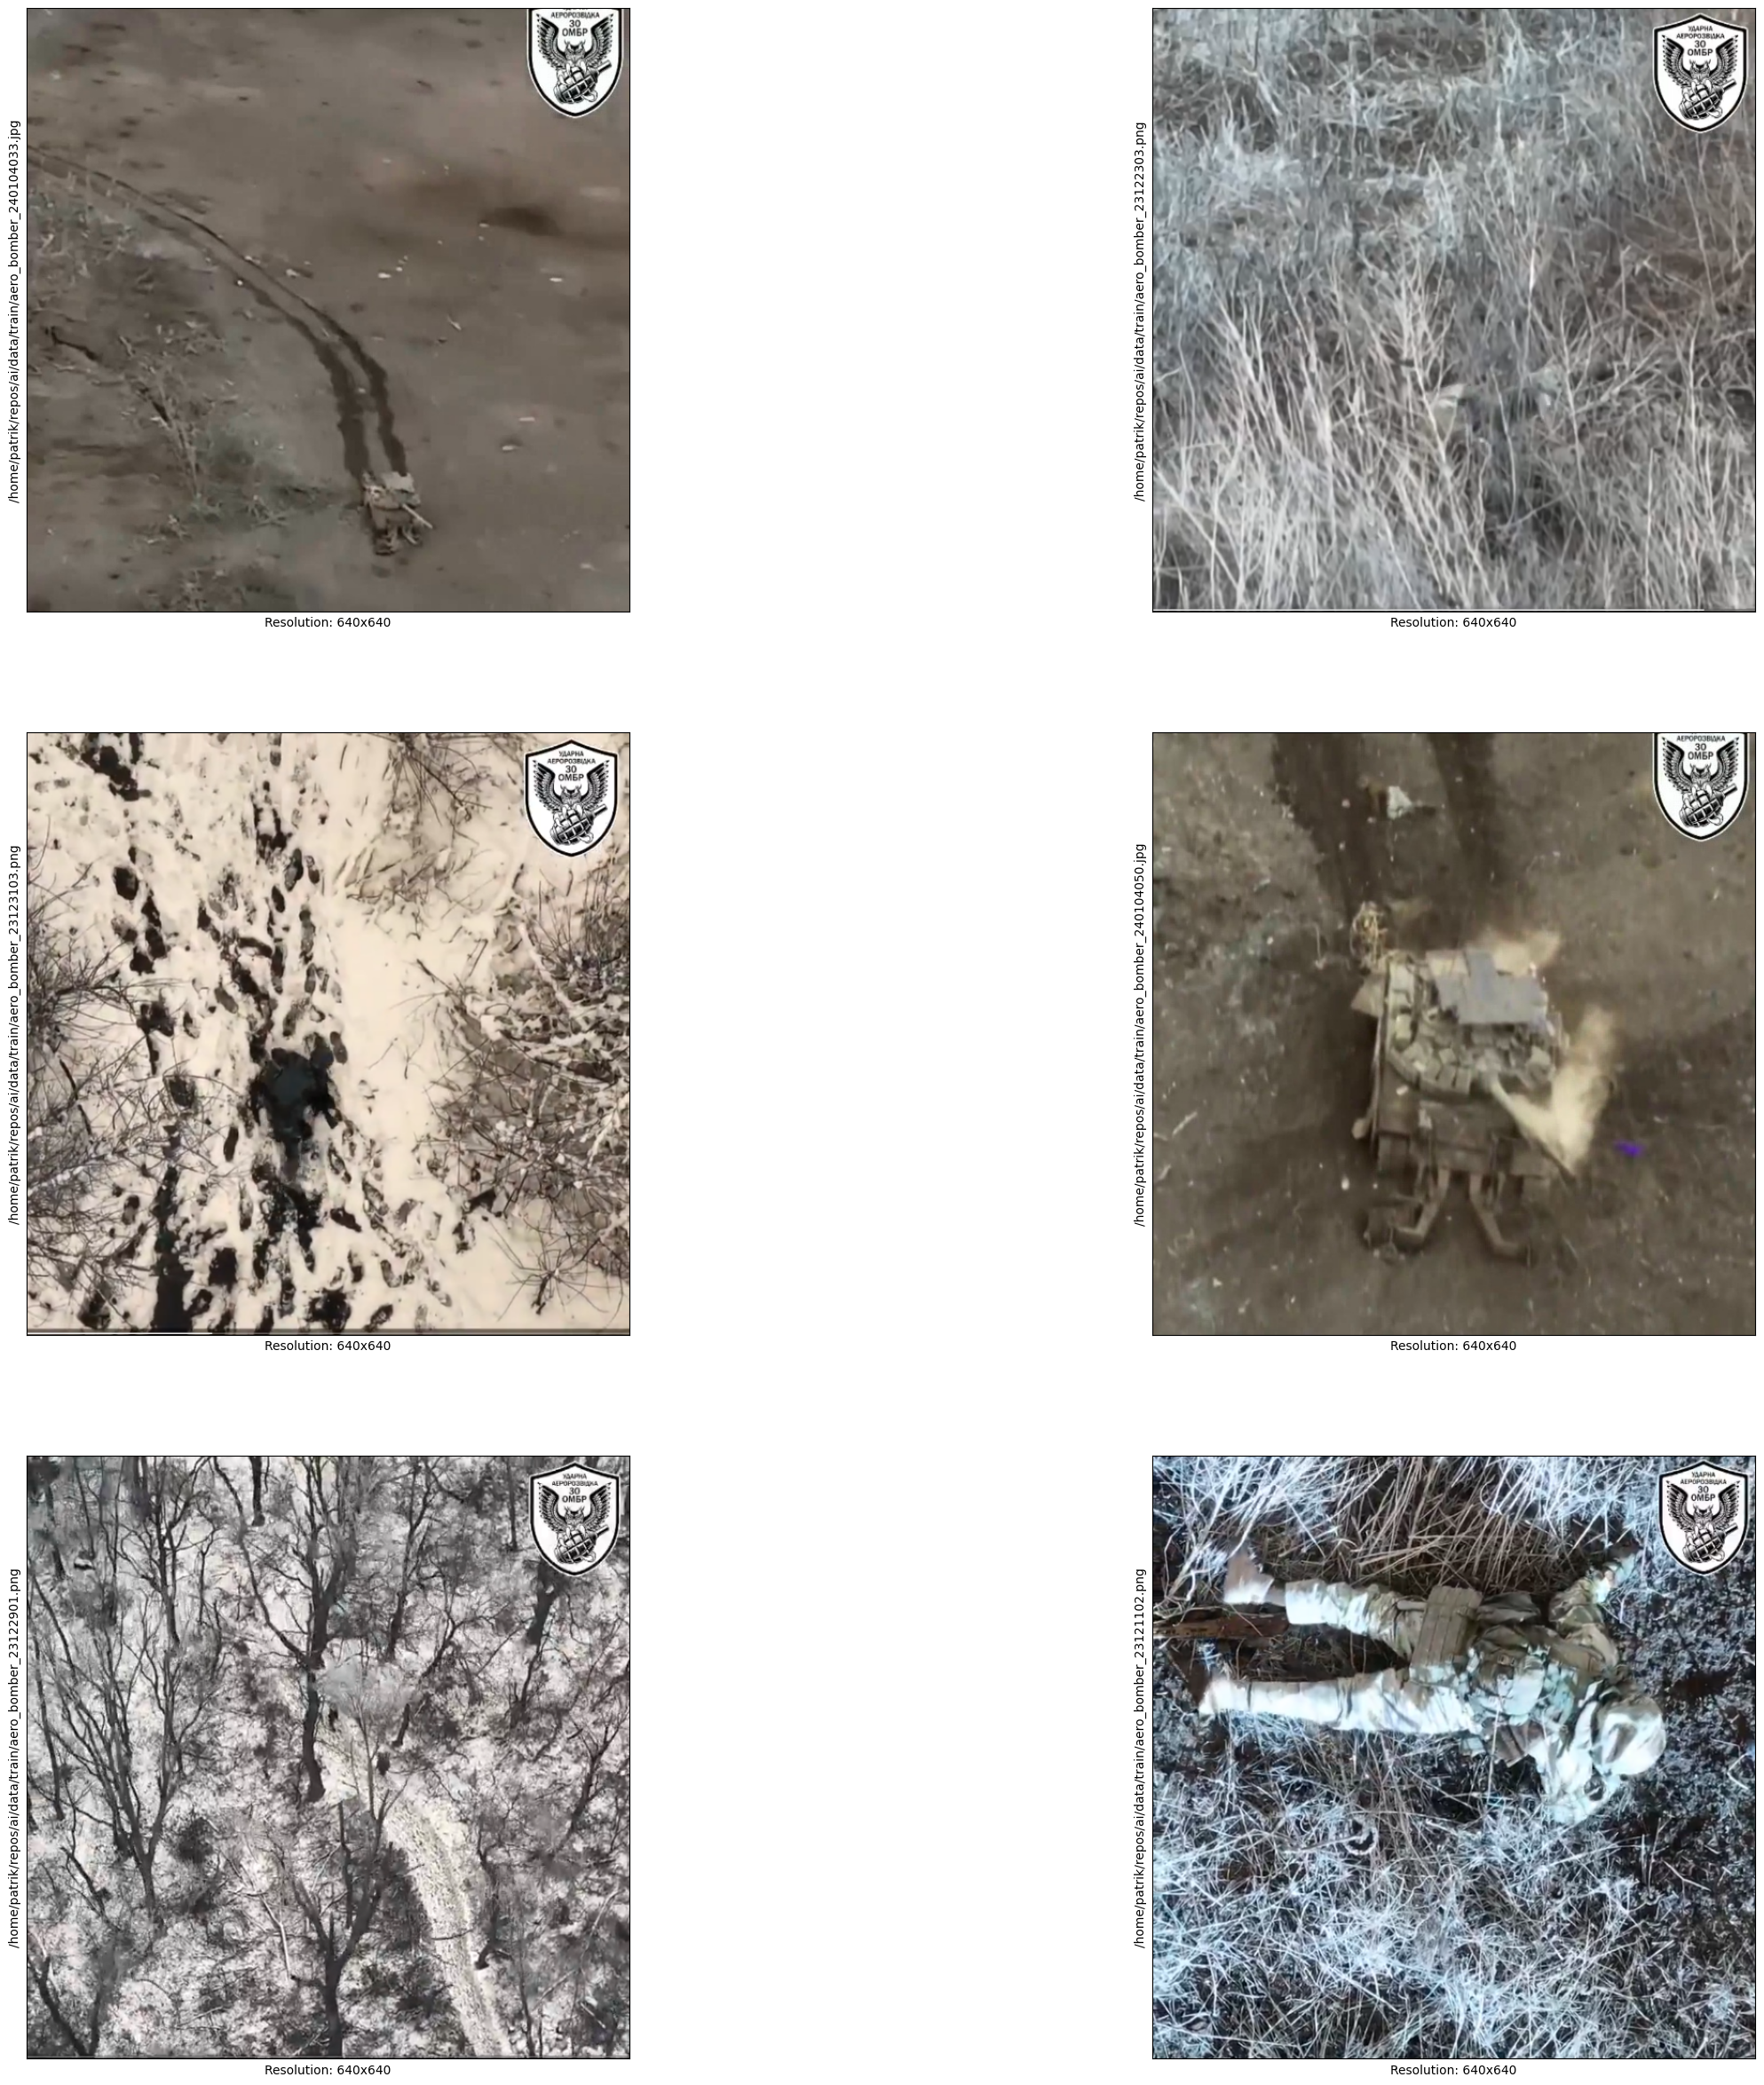

In [ ]:
plt.figure(figsize=(30,30))
random_train_images = random.sample(train_files, 6)

for i, train_image in enumerate(random_train_images):
    if train_image.endswith(('.jpg', '.png')):
        train_image = os.path.basename(train_image)
        image_path = os.path.join(train_dir, train_image)
        image = cv2.imread(image_path)
        resolution = f"Resolution: {image.shape[1]}x{image.shape[0]}"
        ax = plt.subplot(3, 2, i+1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(resolution)
        plt.ylabel(image_path)


In [ ]:
def get_bbox_from_label(text_file_path):
    bbox_list=[]
    image_width = image_height = image_size
    with open(text_file_path, "r") as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split(" "))
            x_center *= image_width
            y_center *= image_height
            width *= image_width
            height *= image_height

            x_min = x_center - (width // 2)
            y_min = y_center - (height // 2)
            x_max = x_center + (width // 2)
            y_max = y_center + (height // 2)

            vertices = np.array([[[x_min, y_min]], [[x_max, y_min]],
                                 [[x_max, y_max]], [[x_min, y_max]]], dtype=np.int32)
            bbox_list.append(vertices)      
    return tuple(bbox_list)

In [ ]:
red=(255,0,0) 

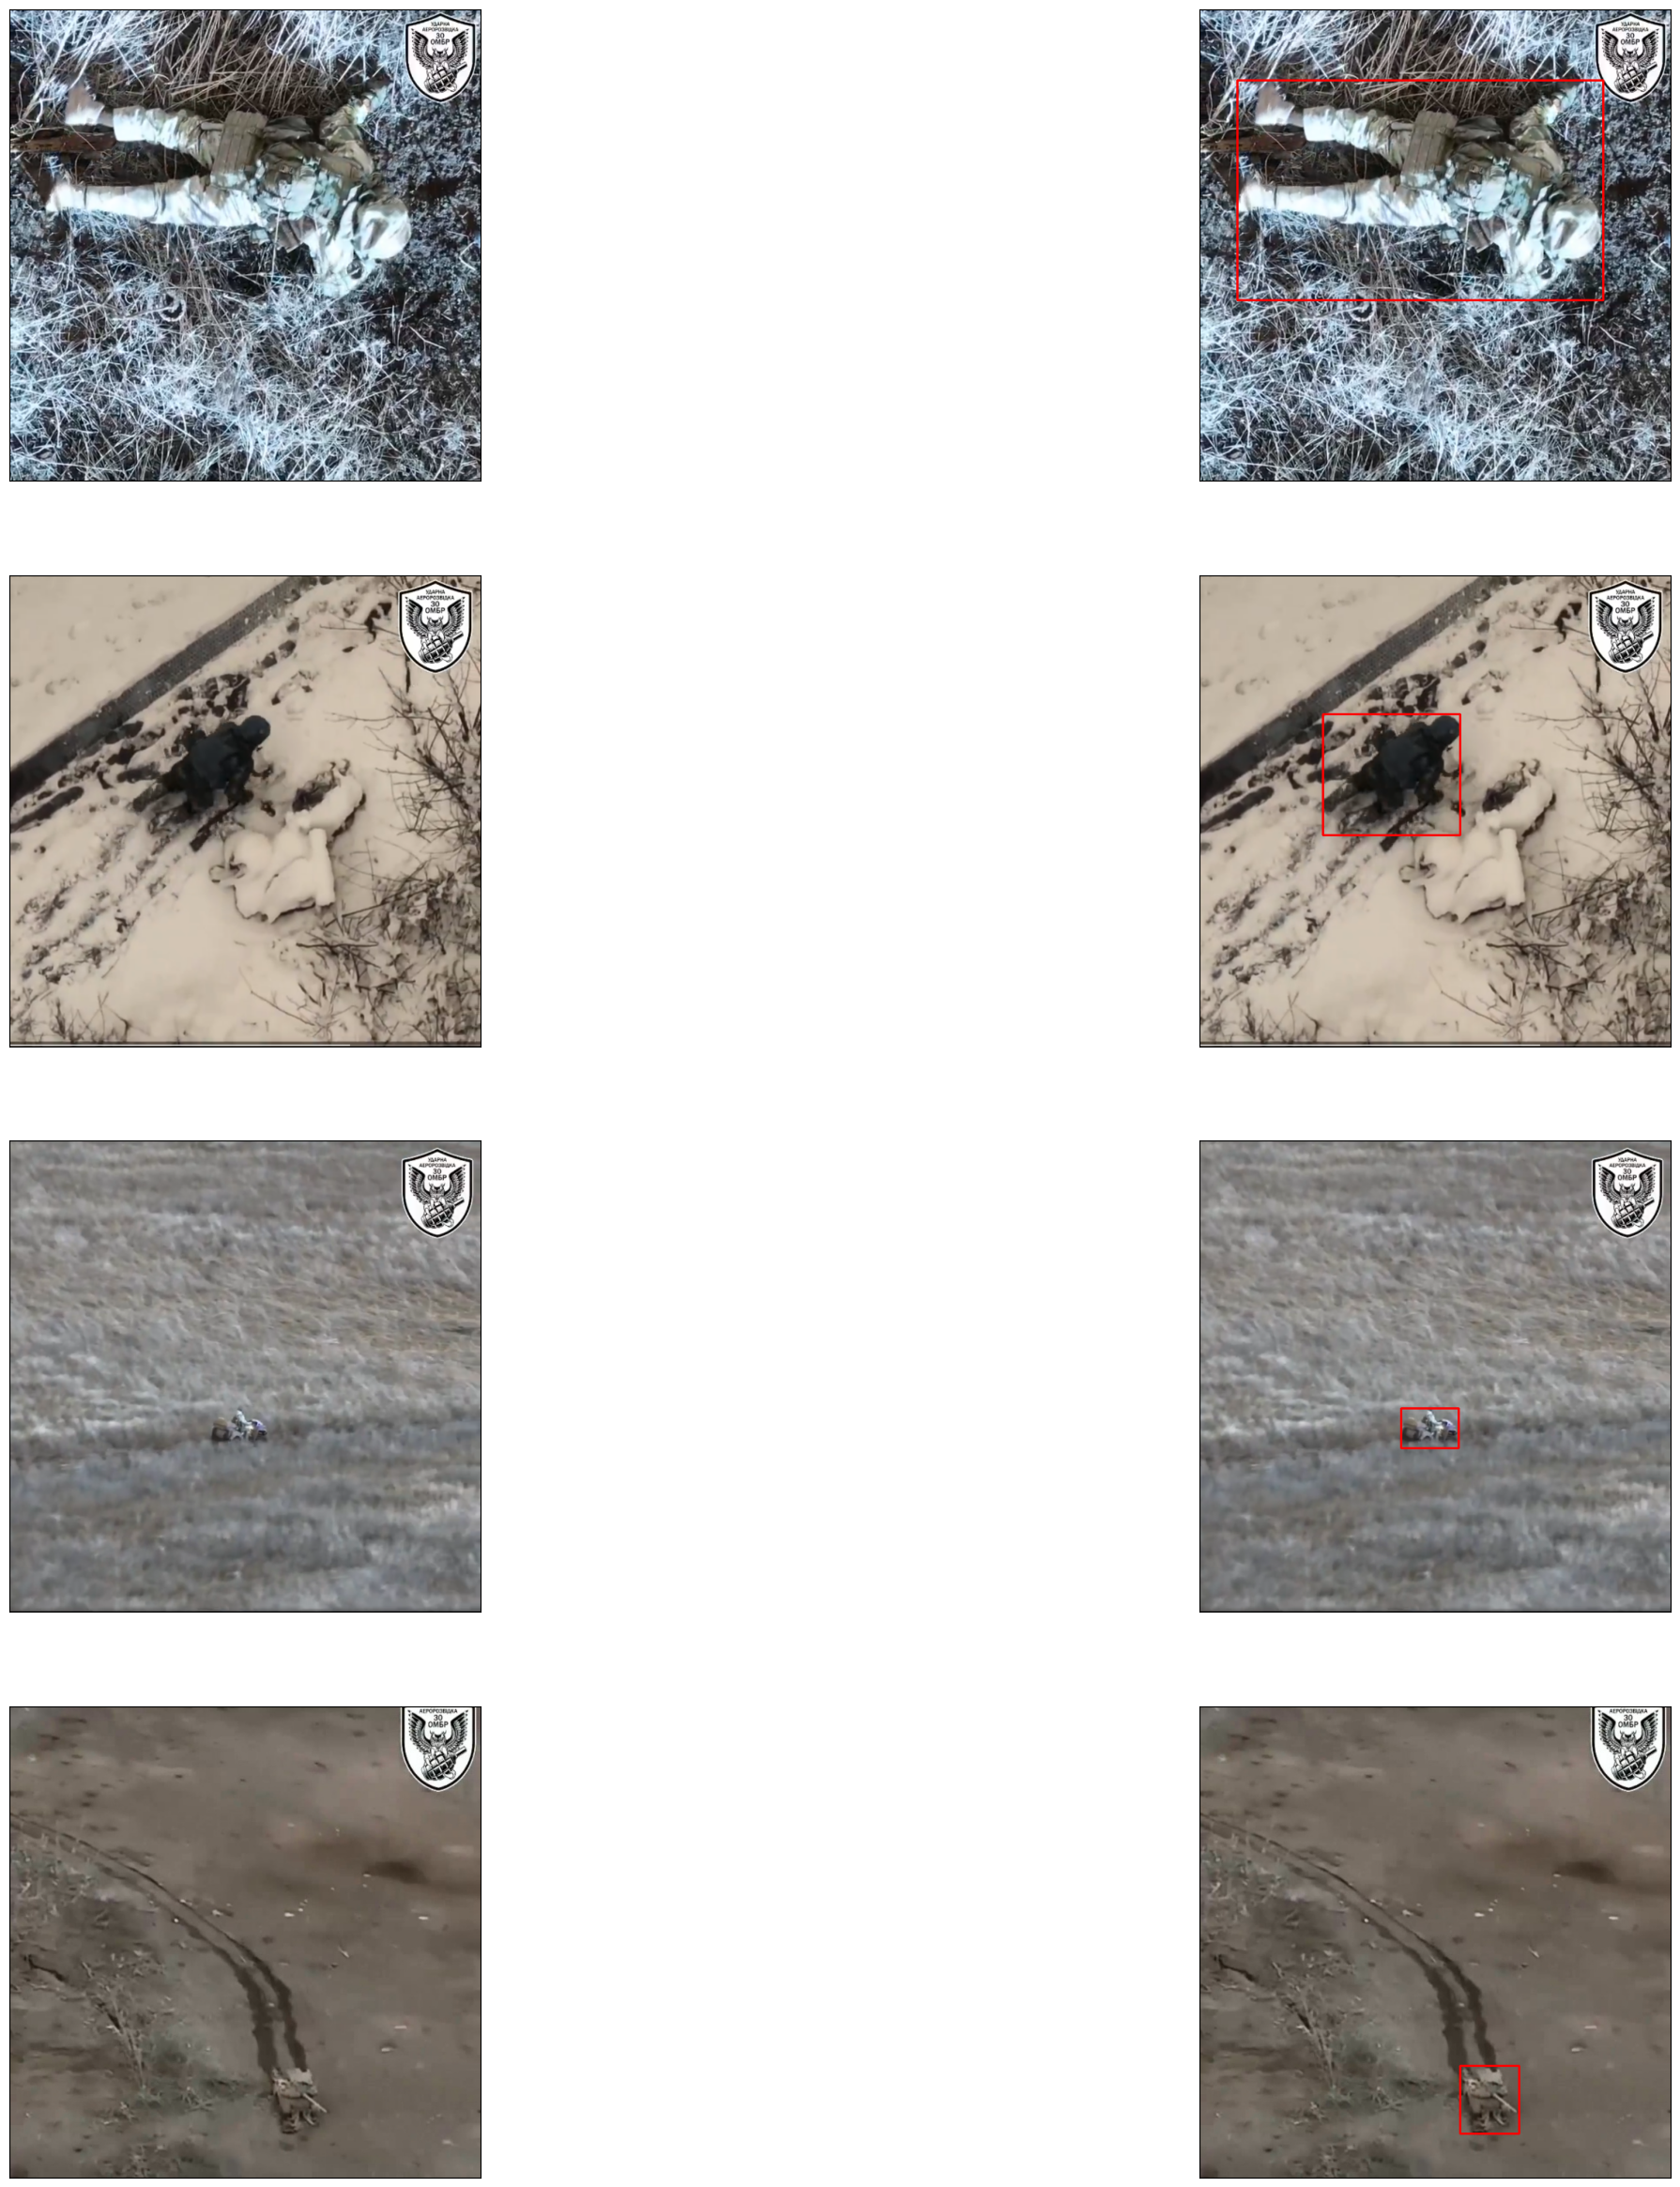

In [ ]:
# Drawing bounding box for random images in training data
plt.figure(figsize=(30,30))
for i in range(1,8,2):
    k=random.randint(0, len(train_files)-1)
    train_file = sorted(train_files)[k]
    img_path = os.path.basename(train_file)
    image_path = os.path.join(train_dir, img_path)
    file_name_without_extension = os.path.splitext(os.path.basename(img_path))[0]
     
    txt_file_name = file_name_without_extension + '.txt'
    label_path = os.path.join(train_dir, txt_file_name)

    bbox=get_bbox_from_label(label_path) # extracting bounding box coordinates
    image=cv2.imread(image_path)
    image_copy=copy.deepcopy(image)
    ax=plt.subplot(4, 2, i)
    plt.imshow(image) # displaying image
    plt.xticks([])
    plt.yticks([])
    cv2.drawContours(image_copy, bbox, -1, red, 2) # drawing bounding box on copy of image
    ax=plt.subplot(4, 2, i+1)
    plt.imshow(image_copy) # displaying image with bounding box
    plt.xticks([])
    plt.yticks([])

In [ ]:
newline='\n'

In [ ]:
# Starting with a comment in config file
ln_1='# Train/val/test sets'+newline

# train, val and test path declaration
ln_2='train: ' +"'"+train_dir+"'"+newline
ln_3='val: ' +"'" + val_dir+"'"+newline
ln_4='test: ' +"'" + test_dir+"'"+newline
ln_5=newline
config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5]

In [ ]:
ln_6='# Classes'+newline

# names of the classes declaration
ln_7='names:'+newline
config_lines.extend([ln_6, ln_7])
for i, name in enumerate(labels_names):
    line = f'  {i}: {name}'+newline
    config_lines.append(line)

In [ ]:
config_path=os.path.join(root, 'config.yaml')
config_path

'/home/patrik/repos/ai/config.yaml'

In [ ]:
with open(config_path, 'w') as f:
    f.writelines(config_lines)